# **Cell 1: Instalasi Library**

**Tujuan: Menginstal dan mengimpor library yang diperlukan untuk preprocessing dan analisis data**



*   Menginstal library untuk preprocessing teks Bahasa Indonesia (Sastrawi),
pengolahan data (pandas, numpy), dan visualisasi (matplotlib, seaborn)

In [ ]:
!pip install Sastrawi
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

# Mengimpor library yang akan digunakan
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import nltk
from collections import Counter
import string

# Download data NLTK untuk tokenisasi
nltk.download('punkt')

print("Semua library berhasil diimport!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.8 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Semua library berhasil diimport!


# **Cell 2: Memuat Data Hasil Scraping**

**Tujuan: Memuat data dari file CSV hasil scraping atau membuat data dummy jika file tidak ditemukan**

In [ ]:
# Memuat data dari file articles_raw.csv hasil tahap scraping
try:
    df = pd.read_csv('/content/articles_raw_cleaned.csv')
    print(f"Data berhasil dimuat: {df.shape}")
except:
    # Fallback: Membuat data dummy jika file tidak ditemukan
    print("File articles_raw.csv tidak ditemukan, menggunakan sample data...")
    data = {
        'id': [0, 1, 2],
        'date': ['2024-01-15', '2024-01-16', '2024-01-17'],
        'source': ['katadata.co.id', 'dailysocial.id', 'tekno.kompas.com'],
        'url': ['http://example.com/1', 'http://example.com/2', 'http://example.com/3'],
        'title': [
            'Startup Fintech Indonesia Gunakan AI untuk Analisis Kredit',
            'Rumah Sakit Terapkan AI untuk Diagnosis Penyakit Jantung',
            'Pemerintah Kembangkan AI untuk Prediksi Kemacetan Jakarta'
        ],
        'content': [
            'Perusahaan fintech X meluncurkan sistem AI yang dapat menganalisis profil kredit nasabah dengan akurasi tinggi. Teknologi machine learning ini membantu mengurangi risiko kredit macet hingga 30%. Implementasi AI di sektor finansial Indonesia semakin masif.',
            'RS Premier Jatinegara mulai menggunakan artificial intelligence untuk mendiagnosis penyakit jantung. AI mampu menganalisis gambar EKG dengan cepat dan akurat. Inovasi ini diharapkan dapat meningkatkan kualitas layanan kesehatan di Indonesia.',
            'Kementerian Perhubungan bekerja sama dengan startup lokal mengembangkan sistem AI untuk memprediksi kemacetan di Jakarta. Sistem menggunakan data real-time dari GPS dan kamera CCTV. Teknologi ini akan diimplementasikan mulai kuartal depan.'
        ]
    }
    df = pd.DataFrame(data)

# Menampilkan informasi dasar dataset
print("Informasi dataset:")
print(f"Shape: {df.shape}")
print(f"Kolom: {df.columns.tolist()}")
print(f"Sample data:")
df.head()

Output hidden; open in https://colab.research.google.com to view.

# **Cell 3: Eksplorasi Data Awal**

**Tujuan: Melakukan analisis awal untuk memahami struktur dan kualitas data**

In [ ]:
# Memeriksa missing values
print("Missing values per kolom:")
print(df.isnull().sum())

# Memeriksa tipe data
print("\nData types:")
print(df.dtypes)

# Menghitung statistik dasar untuk kolom konten
print("\nStatistik konten:")
df['content_length'] = df['content'].str.len()
print(f"Panjang konten rata-rata: {df['content_length'].mean():.0f} karakter")
print(f"Panjang konten min: {df['content_length'].min():.0f} karakter")
print(f"Panjang konten max: {df['content_length'].max():.0f} karakter")

# Menampilkan distribusi sumber berita
print("\nTop 10 sumber berita:")
print(df['source'].value_counts().head(10))

Missing values per kolom:
id                0
date              0
source            0
url               0
title             0
content           0
authors           0
summary           0
content_length    0
dtype: int64

Data types:
id                 int64
date              object
source            object
url               object
title             object
content           object
authors           object
summary           object
content_length     int64
dtype: object

Statistik konten:
Panjang konten rata-rata: 3093 karakter
Panjang konten min: 899 karakter
Panjang konten max: 7445 karakter

Top 10 sumber berita:
source
katadata.co.id         16
www.kompas.com         15
tekno.kompas.com       13
www.viva.co.id          9
money.kompas.com        5
bandung.kompas.com      1
nasional.kompas.com     1
lampung.viva.co.id      1
Name: count, dtype: int64


# Cell 4: Fungsi Preprocessing Teks

**Tujuan: Mendefinisikan fungsi untuk membersihkan, menghapus stopwords, dan stemming teks Bahasa Indonesia**

In [ ]:
# Inisialisasi tools Sastrawi untuk stemming dan stopwords
factory = StemmerFactory()
stemmer = factory.create_stemmer()

stopword_factory = StopWordRemoverFactory()
stopwords = stopword_factory.get_stop_words()

def clean_text(text):
    """
    Membersihkan teks dengan langkah-langkah dasar.
    Args:
        text (str): Teks input untuk dibersihkan
    Returns:
        str: Teks yang telah dibersihkan
    """
    if pd.isna(text):
        return ""

    # Convert ke string
    text = str(text)

    # 1. Mengubah ke huruf kecil
    text = text.lower()

    # 2. Menghapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 3. Menghapus tag HTML
    text = re.sub(r'<.*?>', '', text)

    # 4. Menghapus tanda baca dan angka
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', '', text)

    # 5. Menghapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    # 6. Menghapus kata pendek (<2 karakter)
    text = ' '.join([word for word in text.split() if len(word) > 2])

    return text

def remove_stopwords(text):
    """
    Menghapus stopwords Bahasa Indonesia dari teks.
    Args:
        text (str): Teks input
    Returns:
        str: Teks tanpa stopwords
    """
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords]
    return ' '.join(filtered_words)

def stem_text(text):
    """
    Melakukan stemming pada teks Bahasa Indonesia.
    Args:
        text (str): Teks input
    Returns:
        str: Teks yang telah distem
    """
    return stemmer.stem(text)

def preprocess_pipeline(text, use_stemming=True, use_stopwords=True):
    """
    Pipeline lengkap untuk preprocessing teks.
    Args:
        text (str): Teks input
        use_stemming (bool): Apakah menggunakan stemming
        use_stopwords (bool): Apakah menghapus stopwords
    Returns:
        str: Teks yang telah diproses
    """
    # Cleaning dasar
    cleaned = clean_text(text)

    # Menghapus stopwords
    if use_stopwords:
        cleaned = remove_stopwords(cleaned)

    # Stemming
    if use_stemming:
        cleaned = stem_text(cleaned)

    return cleaned

# **Cell 5: Menerapkan Preprocessing**

**Tujuan: Menerapkan preprocessing pada kolom title dan content**

In [ ]:
print("Memulai preprocessing...")

# Membuat salinan dataframe
df_clean = df.copy()

# Preprocessing untuk kolom title
print("Preprocessing titles...")
df_clean['title_clean'] = df_clean['title'].apply(
    lambda x: preprocess_pipeline(x, use_stemming=True, use_stopwords=True)
)

# Preprocessing untuk kolom content
print("Preprocessing content...")
df_clean['content_clean'] = df_clean['content'].apply(
    lambda x: preprocess_pipeline(x, use_stemming=True, use_stopwords=True)
)

# Menggabungkan title dan content yang telah dibersihkan
df_clean['text_clean'] = df_clean['title_clean'] + ' ' + df_clean['content_clean']

print("Preprocessing selesai!")

# Menampilkan perbandingan sebelum dan sesudah preprocessing
print("\nContoh sebelum dan sesudah preprocessing:")
sample_idx = 0
print("Original title:", df_clean.loc[sample_idx, 'title'])
print("Cleaned title:", df_clean.loc[sample_idx, 'title_clean'])
print("\nOriginal content (100 karakter pertama):", df_clean.loc[sample_idx, 'content'][:100])
print("Cleaned content (100 karakter pertama):", df_clean.loc[sample_idx, 'content_clean'][:100])

Memulai preprocessing...
Preprocessing titles...
Preprocessing content...
Preprocessing selesai!

Contoh sebelum dan sesudah preprocessing:
Original title: Petugas Telah Padamkan Kebakaran Hunian Pekerja Proyek IKN, Penghuni Dipindahkan
Cleaned title: tugas padam bakar huni kerja proyek ikn huni pindah

Original content (100 karakter pertama): Otorita Ibu Kota Nusantara (IKN) mengatakan kebakaran di hunian pekerja konstruksi telah berhasil di
Cleaned content (100 karakter pertama): otorita ibu kota nusantara ikn kata bakar huni kerja konstruksi hasil padam pukul wita tengah pindah


# **Cell 6: Analisis Kualitas Setelah Preprocessing**

**Tujuan: Menganalisis dampak preprocessing pada panjang teks dan menampilkan visualisasi**

Statistik setelah preprocessing:
Reduksi teks rata-rata: 34.1%
Panjang cleaned text rata-rata: 2075 karakter


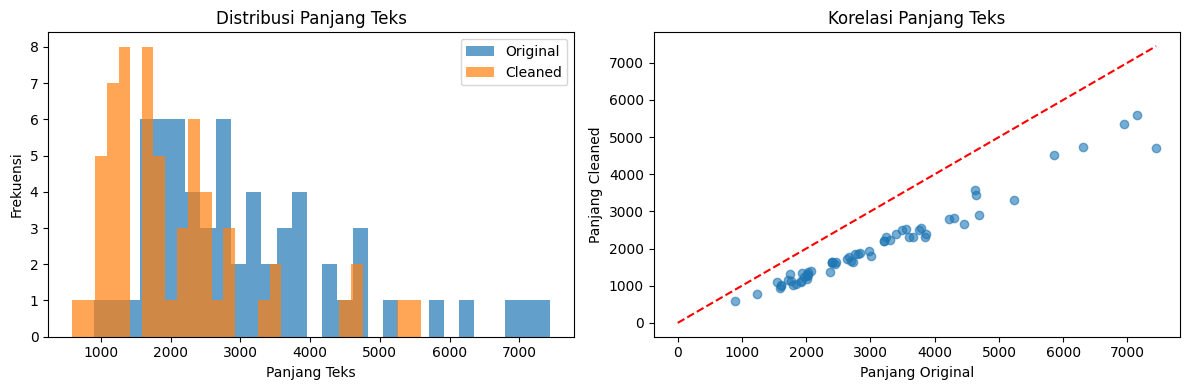

In [ ]:
# Menghitung panjang teks sebelum dan sesudah preprocessing
df_clean['original_length'] = df_clean['content'].str.len()
df_clean['cleaned_length'] = df_clean['content_clean'].str.len()
df_clean['reduction_ratio'] = (df_clean['original_length'] - df_clean['cleaned_length']) / df_clean['original_length']

print("Statistik setelah preprocessing:")
print(f"Reduksi teks rata-rata: {df_clean['reduction_ratio'].mean()*100:.1f}%")
print(f"Panjang cleaned text rata-rata: {df_clean['cleaned_length'].mean():.0f} karakter")

# Visualisasi perbandingan panjang teks
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df_clean['original_length'], bins=30, alpha=0.7, label='Original')
plt.hist(df_clean['cleaned_length'], bins=30, alpha=0.7, label='Cleaned')
plt.xlabel('Panjang Teks')
plt.ylabel('Frekuensi')
plt.legend()
plt.title('Distribusi Panjang Teks')

plt.subplot(1, 2, 2)
plt.scatter(df_clean['original_length'], df_clean['cleaned_length'], alpha=0.6)
plt.plot([0, df_clean['original_length'].max()], [0, df_clean['original_length'].max()], 'r--')
plt.xlabel('Panjang Original')
plt.ylabel('Panjang Cleaned')
plt.title('Korelasi Panjang Teks')

plt.tight_layout()
plt.show()

# **Cell 7: Persiapan Labeling Sektor**

**Tujuan: Mendefinisikan kategori sektor dan fungsi untuk menyarankan sektor berdasarkan kata kunci**

Kategori sektor yang akan digunakan:
1. fintech
2. healthtech
3. edutech
4. ecommerce
5. manufaktur
6. government
7. other

Memberikan sementara label sektor...

Distribusi suggested sectors:
suggested_sector
other         21
government    15
manufaktur     9
edutech        9
fintech        4
healthtech     3
Name: count, dtype: int64


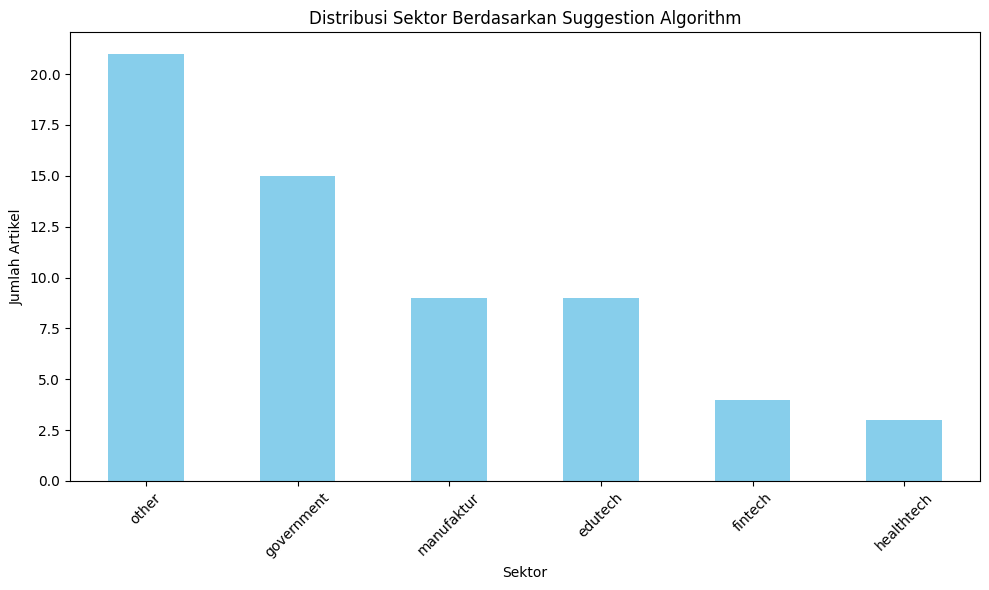

In [ ]:
# Mendefinisikan kategori sektor
sectors = [
    'fintech', 'healthtech', 'edutech', 'ecommerce',
    'manufaktur', 'government', 'other'
]

print("Kategori sektor yang akan digunakan:")
for i, sector in enumerate(sectors, 1):
    print(f"{i}. {sector}")

def suggest_sector(text):
    """
    Menyarankan kategori sektor berdasarkan kata kunci dalam teks.
    Args:
        text (str): Teks input untuk analisis
    Returns:
        str: Nama sektor yang disarankan
    """
    text_lower = text.lower()

    # Kata kunci untuk setiap sektor
    sector_keywords = {
        'fintech': ['bank', 'fintech', 'keuangan', 'kredit', 'pinjaman', 'investasi', 'asuransi'],
        'healthtech': ['rumah sakit', 'kesehatan', 'medis', 'dokter', 'pasien', 'diagnosis', 'klinik'],
        'edutech': ['sekolah', 'pendidikan', 'guru', 'murid', 'kampus', 'universitas', 'belajar'],
        'ecommerce': ['e-commerce', 'tokopedia', 'shopee', 'bukalapak', 'online shop', 'marketplace'],
        'manufaktur': ['pabrik', 'manufaktur', 'produksi', 'industri', 'mesin', 'factory'],
        'government': ['pemerintah', 'kementerian', 'menteri', 'presiden', 'gubernur', 'pemda']
    }

    for sector, keywords in sector_keywords.items():
        if any(keyword in text_lower for keyword in keywords):
            return sector

    return 'other'

# Menerapkan saran sektor untuk semua artikel
print("\nMemberikan sementara label sektor...")
df_clean['suggested_sector'] = df_clean['text_clean'].apply(suggest_sector)

# Menampilkan distribusi sektor yang disarankan
print("\nDistribusi suggested sectors:")
sector_counts = df_clean['suggested_sector'].value_counts()
print(sector_counts)

# Visualisasi distribusi sektor
plt.figure(figsize=(10, 6))
sector_counts.plot(kind='bar', color='skyblue')
plt.title('Distribusi Sektor Berdasarkan Suggestion Algorithm')
plt.xlabel('Sektor')
plt.ylabel('Jumlah Artikel')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Cell 8: Membuat Sample untuk Labeling Manual**

**Tujuan: Memilih sampel acak untuk labeling manual dengan distribusi proporsional**

In [ ]:
# Memilih sampel acak untuk labeling manual
np.random.seed(42)
sample_size = min(300, len(df_clean))

# Stratified sampling berdasarkan suggested sector
labeled_sample = pd.DataFrame()
for sector in sectors:
    sector_data = df_clean[df_clean['suggested_sector'] == sector]
    if len(sector_data) > 0:
        n_sample = max(1, int(sample_size * len(sector_data) / len(df_clean)))
        sampled = sector_data.sample(n=min(n_sample, len(sector_data)), random_state=42)
        labeled_sample = pd.concat([labeled_sample, sampled])

# Reset index
labeled_sample = labeled_sample.reset_index(drop=True)

# Menambahkan kolom untuk labeling manual
labeled_sample['manual_sector'] = labeled_sample['suggested_sector']
labeled_sample['confidence'] = ''

print(f"Labeled sample created: {len(labeled_sample)} articles")
print("Distribusi labeled sample:")
print(labeled_sample['suggested_sector'].value_counts())

# Menampilkan sampel untuk review manual
print("\nSample untuk review manual:")
for i, row in labeled_sample.head(5).iterrows():
    print(f"\n--- Artikel {i+1} ---")
    print(f"Title: {row['title']}")
    print(f"Suggested Sector: {row['suggested_sector']}")
    print(f"Content preview: {row['content'][:200]}...")

Labeled sample created: 61 articles
Distribusi labeled sample:
suggested_sector
other         21
government    15
manufaktur     9
edutech        9
fintech        4
healthtech     3
Name: count, dtype: int64

Sample untuk review manual:

--- Artikel 1 ---
Title: BP-Shell Blak-blakan Ungkap Penyebab BBM Langka di SPBU Swasta, Impor Dibatasi
Suggested Sector: fintech
Content preview: Kelangkaan bahan bakar minyak (BBM) di SPBU swasta mulai terjadi sejak Agustus 2025. Presiden Direktur BP-AKR, Vanda Laura mengatakan pihaknya sudah melihat potensi keterbatasan stok sejak Juni 2025.
...

--- Artikel 2 ---
Title: Potensi Ekonomi Besar, Fintech dan Asuransi Garis Depan Adopsi AI
Suggested Sector: fintech
Content preview: JAKARTA, KOMPAS.com – Indonesia tengah berada di persimpangan penting dalam peta ekonomi digital Asia Tenggara.

Dengan proyeksi kontribusi kecerdasan buatan (AI) global mencapai 15,7 triliun dollar A...

--- Artikel 3 ---
Title: DPR Sahkan RUU BUMN di Rapat Paripurna Besok
S

# **Cell 9: Menyimpan Hasil Preprocessing**

**Tujuan: Menyimpan data yang telah diproses dan sampel untuk labeling**

In [ ]:
# Membuat direktori untuk menyimpan file
import os
os.makedirs('data/processed', exist_ok=True)

# Menyimpan data yang telah dibersihkan
output_clean = 'data/processed/articles_clean.csv'
df_clean.to_csv(output_clean, index=False, encoding='utf-8')
print(f"Data cleaned disimpan: {output_clean}")

# Menyimpan sampel untuk labeling
output_labeled = 'data/processed/labeled_sample.csv'
labeled_sample[['id', 'date', 'source', 'url', 'title', 'content', 'title_clean', 'content_clean', 'suggested_sector', 'manual_sector', 'confidence']].to_csv(output_labeled, index=False, encoding='utf-8')
print(f"Labeled sample disimpan: {output_labeled}")

# Menyimpan dataset lengkap untuk inference
output_full = 'data/processed/full_dataset_clean.csv'
df_clean[['id', 'date', 'source', 'url', 'title', 'content', 'text_clean']].to_csv(output_full, index=False, encoding='utf-8')
print(f"Full dataset untuk inference disimpan: {output_full}")

Data cleaned disimpan: data/processed/articles_clean.csv
Labeled sample disimpan: data/processed/labeled_sample.csv
Full dataset untuk inference disimpan: data/processed/full_dataset_clean.csv


# **Cell 10: Analisis Kata Kunci per Sektor**

**Tujuan: Menganalisis kata kunci yang sering muncul di setiap sektor**

In [ ]:
# Menganalisis kata kunci yang muncul di setiap sektor
print("Analisis kata kunci per sektor:")

for sector in sectors:
    sector_texts = df_clean[df_clean['suggested_sector'] == sector]['text_clean']
    if len(sector_texts) > 0:
        all_words = ' '.join(sector_texts).split()
        word_freq = Counter(all_words)
        top_words = word_freq.most_common(10)

        print(f"\n{sector.upper()} - Top 10 kata kunci:")
        for word, freq in top_words:
            print(f"  {word}: {freq}")

Analisis kata kunci per sektor:

FINTECH - Top 10 kata kunci:
  bumn: 23
  undang: 12
  kata: 12
  spbu: 12
  rapat: 11
  usaha: 11
  tingkat: 11
  sebut: 11
  atur: 11
  menteri: 10

HEALTHTECH - Top 10 kata kunci:
  gaza: 17
  nilai: 17
  teknologi: 15
  manusia: 14
  jadi: 13
  kata: 11
  orang: 11
  sebut: 10
  israel: 10
  serang: 9

EDUTECH - Top 10 kata kunci:
  anak: 37
  korban: 36
  partai: 35
  jadi: 31
  tahun: 26
  sebut: 25
  sekolah: 24
  guru: 20
  baca: 20
  pimpin: 20

MANUFAKTUR - Top 10 kata kunci:
  model: 34
  batik: 31
  guna: 28
  kerja: 28
  manusia: 26
  jadi: 25
  claude: 25
  buat: 24
  foto: 23
  lebih: 22

GOVERNMENT - Top 10 kata kunci:
  kata: 61
  menteri: 36
  kerja: 30
  jadi: 30
  sebut: 27
  jakarta: 25
  huni: 21
  baca: 21
  kepala: 20
  bakar: 19

OTHER - Top 10 kata kunci:
  foto: 243
  gemini: 106
  jadi: 101
  gaya: 93
  wajah: 87
  prompt: 84
  edit: 84
  hasil: 82
  guna: 82
  ubah: 76


# **Cell 11: Pemeriksaan Kualitas Akhir**

**Tujuan: Melakukan pemeriksaan kualitas akhir dan merangkum hasil preprocessing**

In [ ]:
# Pemeriksaan kualitas akhir
print("\n" + "="*50)
print("QUALITY CHECK FINAL")
print("="*50)

print(f"✓ Total artikel: {len(df_clean)}")
print(f"✓ Artikel dengan konten valid: {len(df_clean[df_clean['content_clean'].str.len() > 50])}")
print(f"✓ Reduksi teks rata-rata: {df_clean['reduction_ratio'].mean()*100:.1f}%")
print(f"✓ Sektor terdistribusi: {df_clean['suggested_sector'].nunique()} kategori")
print(f"✓ Labeled sample tersedia: {len(labeled_sample)} artikel")
print(f"✓ File tersimpan:")
print(f"  - {output_clean}")
print(f"  - {output_labeled}")
print(f"  - {output_full}")

print("\n🎉 PREPROCESSING SELESAI!")
print("Data siap untuk inference dengan IBM Granite!")


QUALITY CHECK FINAL
✓ Total artikel: 61
✓ Artikel dengan konten valid: 61
✓ Reduksi teks rata-rata: 34.1%
✓ Sektor terdistribusi: 6 kategori
✓ Labeled sample tersedia: 61 artikel
✓ File tersimpan:
  - data/processed/articles_clean.csv
  - data/processed/labeled_sample.csv
  - data/processed/full_dataset_clean.csv

🎉 PREPROCESSING SELESAI!
Data siap untuk inference dengan IBM Granite!
